Beginning Imports

In [18]:
%pylab inline
import os
import time
import glob
import operator
import xarray as xr
import itertools
import summa_plot as sp
import pysumma.Simulation
import scipy.stats
import matplotlib as mpl
from pprint import pprint
from functools import reduce
from scipy.special import psi, inv_boxcox
from jupyterthemes import jtplot
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import importlib
from jupyterthemes import jtplot
importlib.reload(pysumma.Simulation)

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)
mpl.rcParams['figure.figsize'] = (18, 10)

MM_PER_M = 1000
SEC_PER_MIN = 60
MIN_PER_HOUR = 60
HOUR_PER_DAY = 24
DAY_PER_YEAR = 365
# Timestep is 1 hour in our case
SEC_PER_TIMESTEP = SEC_PER_MIN * MIN_PER_HOUR

user = os.environ['USER']
sites = ['Amplero', 'Blodgett', 'Bugac', 'ElSaler', 'ElSaler2', 'Espirra', 'FortPeck', 
         'Harvard', 'Hesse', 'Howard', 'Howlandm', 'Hyytiala', 'Kruger', 'Loobos', 'Merbleue',
         'Mopane', 'Palang', 'Sylvania', 'Tumba', 'UniMich']
soil_moisture_sites = ['Amplero', 'Blodgett', 'ElSaler', 'ElSaler2', 'FortPeck', 'Hesse', 
                       'Hyytiala', 'Kruger', 'Loobos', 'Mopane', 'Sylvania']
fman_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"
oc_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/meta/summa_zModelOutput.txt"
fman_dict = {s: fman_template.format(s, s) for s in sites}

Populating the interactive namespace from numpy and matplotlib


In [19]:
wb_vars = ['pptrate', 'scalarGroundEvaporation', 'scalarCanopyEvaporation',
           'scalarSnowSublimation', 'scalarCanopySublimation', 'scalarTotalRunoff', 
           'scalarSWE', 'scalarTotalSoilLiq',  'scalarTotalSoilIce', 
           'scalarCanopyIce', 'scalarCanopyLiq', 'scalarCanopyTranspiration', 
           'scalarLatHeatTotal', 'scalarSenHeatTotal', 'airtemp', 'SWRadAtm']

wb_dict = {
    'precip': ['pptrate'],
    'evap': ['scalarGroundEvaporation', 'scalarCanopyEvaporation', 'scalarCanopyTranspiration', 
             'scalarSnowSublimation', 'scalarCanopySublimation'],
    'runoff': ['scalarTotalRunoff'],
    'swe': ['scalarSWE'],
    'soil_moisture': ['scalarTotalSoilLiq', 'scalarTotalSoilIce'],
    'canopy_moisture': ['scalarCanopyIce', 'scalarCanopyLiq'],
    'latent_heat': ['scalarLatHeatTotal'],
    'sensible_heat': ['scalarSenHeatTotal'],
    'temperature': ['airtemp'],
    'shortwave': ['SWRadAtm']
}

wb_multiplier = {
    'precip': SEC_PER_TIMESTEP,
    'evap': SEC_PER_TIMESTEP,
    'runoff': SEC_PER_TIMESTEP * MM_PER_M,
    'swe': 1,
    'soil_moisture': 1,
    'canopy_moisture': 1,
    'latent_heat': -1,
    'sensible_heat': -1,
    'temperature': 1,
    'shortwave': 1
}

Info Analysis Functions

In [26]:
def raw_data(data_array):
    """Unpacks data into a flat array"""
    eps = 1e-12
    return data_array.values.flatten() + eps * np.random.random(data_array.shape)


def good_inds(x, strict=False):
    """Remove invalid data"""
    if strict:
        return np.where(np.logical_and(x > 1e-10, x < 3000))[0]
    return np.where(np.logical_and(x > -3000, x < 3000))[0]

def good_data(x, strict=False):
    return x[good_inds(x, strict=strict)]

def nearest_distances(X, k=1):
    """Compute distances to kth nearest neighbors"""
    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    return d[:, -1]


def marginal_neighbors(X, R):
    """Compute number of neighbors in R-radius ball"""
    knn = NearestNeighbors(metric='chebyshev')
    knn.fit(X)
    return np.array([len(knn.radius_neighbors(p.reshape(1, -1), r)[0][0])
                     for p, r in zip(X, R)])


def entropy_sk(X, k=False):
    """Compute entropy H(X1, X2,..., Xn)"""
    try:
        n, d = X.shape
    except Exception as e:
        X = X.reshape(-1, 1)
        n, d = X.shape
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(X, k) + eps * np.random.random(n)
    n, d = X.shape
    ent = d * np.log(np.mean(r)) + psi(n) - psi(k) + d * np.log(2)
    return ent


def mutual_info(x, y, k=False):
    """Compute I(X; Y)"""
    n = len(x)
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(np.array([x, y]).T, k) + eps * np.random.random(n)
    n_x = marginal_neighbors(x.reshape(-1,1), r)
    n_y = marginal_neighbors(y.reshape(-1,1), r)
    psi_x = psi(n_x)
    psi_y = psi(n_y)
    return (psi(n) + psi(k) - (1./k) - np.mean(psi_x + psi_y))


def conditional_mutual_info(X, k=False):
    """Compute I(X1; X2 | X3:n)"""
    xz = np.array([X[0], *X[2:]]).T
    yz = np.array([X[1], *X[2:]]).T
    z = np.array(X[2:]).T
    d, n = X.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(X.T, k) + eps * np.random.random(n)
    n_xz = marginal_neighbors(xz, r)
    n_yz = marginal_neighbors(yz, r)
    n_z = marginal_neighbors(z, r)
    psi_xz = psi(n_xz)
    psi_yz = psi(n_yz)
    psi_z = psi(n_z)
    return psi(k) - np.mean(psi_xz + psi_yz - psi_z)
    #return (psi(k) - (2./k) - np.mean(-psi_z + psi_xz + psi_yz - (1/n_xz) - (1/n_yz)))

def transfer_entropy(X: np.array, lag: int, window: int) -> float:
    """
    Computes TE(X2_t; X1_{t-lag} | X2_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip] will compute
           the information transferred from precip to evap,
        lag: The time-offset to consider (in timesteps).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    assert len(X) == 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag-window])
    max_start = len(X[0]) - sample_size - lag - window
    idx = np.random.choice(np.arange(lag+window, len(X[0])) - lag - window, sample_size)
    cmis = []
    for w in range(window):
        ans = [X[1][idx]]
        ans.append(X[0][idx-w-lag])
        ans.append(X[1][idx-1])
        cmis.append(conditional_mutual_info(np.array(ans)))
    return np.sum(cmis)
   

def conditional_transfer_entropy(X: np.array, lag: int, window: int) -> float:
    """
    Computes TE(X1_t; X2_{t-lag} | X3:n_{t-lag}, X1_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip, runoff] will compute
           the information transferred from precip to evap,
           eliminating any effects from runoff.
        lag: The time-offset to consider (in days).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    # Need at least 3 variables to compute the TE
    assert len(X) > 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag-window])
    max_start = len(X[0]) - sample_size - lag - window
    idx = np.random.choice(np.arange(lag+window, len(X[0])), sample_size)
    cmis = []
    for w in range(window):
        ans = [X[1][idx]]
        ans.append(X[0][idx-w-lag])
        for v in X[2:]:
            ans.append(v[idx-w-lag])
        ans.append(X[1][idx-1])
        cmis.append(conditional_mutual_info(np.array(ans)))
    return np.sum(cmis)


def mutual_info_analysis_full_lagged(ds, out_name, lag=0, window=3, sample_size=3000):
    """
    Compute the mutual information or transfer entropy of variables of
    interest for a dataset.  
    """
    precip = raw_data(ds['precip'])
    temp = raw_data(ds['temperature'])
    soil_moist = raw_data(ds['soil_moisture'])
    lat_heat = raw_data(ds['latent_heat'])
    sen_heat = raw_data(ds['sensible_heat'])
    swrad = raw_data(ds['shortwave'])
    
    names = ['precipitation', 'temperature', 'soil_moisture', 'latent_heat', 'sensible_heat', 'shortwave']
    varlist = [precip, temp, soil_moist, lat_heat, sen_heat, swrad]
    good_data = reduce(np.intersect1d, [good_inds(v) for v in varlist])
    varlist = np.array([v[good_data] for v in varlist])
    
    # Compute indices for subsampling
    sample_size = np.min([sample_size, len(varlist[0])-lag])
    idx = np.random.choice(np.arange(len(varlist[0])-lag), sample_size, replace=False)+lag
    
    # Calculate all needed variable combinations
    mapping = {n: d for n, d in zip(names, varlist)}
    permutations = [list(l) for l in list(itertools.permutations(names, 2))]
    for combo in permutations:
        n = [n for n in names if n not in combo ]
        [combo.append(nn) for nn in n]   
        
    # Subsample data and put it together with combination list
    analysis_sets = []
    for combo in permutations:
        analysis_sets.append([mapping[c] for c in combo])
    
    # Compute scores
    scores = []
    for c, s in zip(permutations, analysis_sets):
        scores.append(conditional_transfer_entropy(s, lag, window))
       
    # Reformat into a nice dataframe, save it, and return
    df = pd.DataFrame(columns=names, index=names)
    for link, score in zip(permutations, scores):
        if score < 1e-6:
            score = 0
        d = {'name_x': link[0], 'name_y': link[1], 'value': score}
        df.loc[link[0], link[1]] = score
    for name, var in zip(names, varlist):
        e_tot = entropy_sk(var[idx])
        #print('computing unexplained entropy for {}: {}'.format(name, e_tot))
        e_tot -= df[name].sum(skipna=True)
        df[name][name] = e_tot
    df.to_csv('../data/{}.csv'.format(out_name))
    return df

def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    ds = ds[list(wb_dict.keys())].isel(hru=0, drop=True)
    ds['dswe'] = ds['swe']
    ds['dsoil_moisture'] = ds['soil_moisture'].diff(dim='time')
    return ds

def rmse(da1, da2):
    return np.sqrt(np.mean(np.power(da1-da2,2))).values

def mbe(da1, da2):
    return (np.sum(da1-da2) / len(da1.values)).values

def r(da1, da2):
    return scipy.stats.pearsonr(da1.values.flatten(),
                                da2.values.flatten())[0]

def dtw(da1, da2):
    return fastdtw(da1.values.flatten(), da2.values.flatten())[0]

In [22]:
bench_files[4]

'/pool0/data/tushark/PLUMBER_data/sites/Amplero/benchmark/AmpleroFluxnet_1.4_PLUMBER_benchmarks.nc'

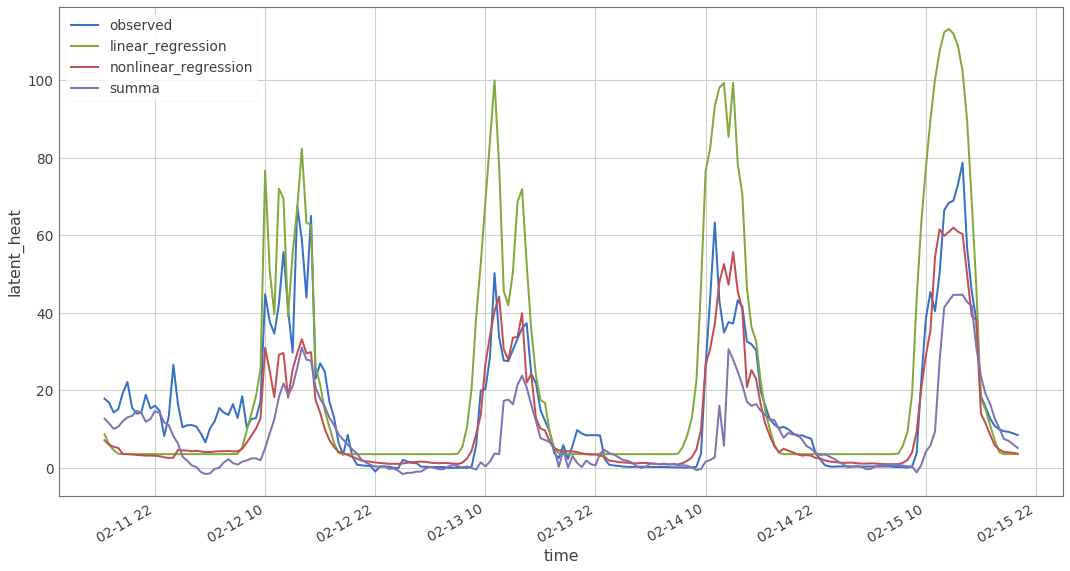

In [24]:
out_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/summa_output/*output*.nc', recursive=True)
bench_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/benchmark/*.nc', recursive=True)
obs_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/observations/fluxes/*.nc', recursive=True)
met_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/observations/met/*.nc', recursive=True)

output =  postprocess(xr.open_dataset('/pool0/data/tushark/PLUMBER_data/sites/Amplero/summa_output/Amplero_output_simplExp_exponential_BallBerry_timestep.nc'))

obs = xr.open_dataset(obs_files[4])
bench = xr.open_dataset(bench_files[4])
met = xr.open_dataset(met_files[4])

ts = slice(2000, 2200)
obs['Qle'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qle_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qle_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
(output['latent_heat']).isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

In [ ]:
obs_files[19]

In [27]:
mutual_info_analysis_full_lagged(output, 'test_output', lag=0, window=3, sample_size=50)

,precipitation,temperature,soil_moisture,latent_heat,sensible_heat,shortwave
precipitation,-0.0870442,0,0,0,0,0
temperature,0,3.63837,0,0,0.00597943,0
soil_moisture,0,0,5.10446,0.101069,0.122713,0.0630679
latent_heat,0,0,0,4.81593,0.166995,0.100706
sensible_heat,0,0,0,0.197011,5.34191,0.116057
shortwave,0,0.00487758,0,0.291919,0.196476,6.45719


In [16]:
print(rmse(output['latent_heat'], obs['Qle']))
print(mbe(output['latent_heat'], obs['Qle']))
print(r(output['latent_heat'], obs['Qle']))
print(dtw(output['latent_heat'], obs['Qle']))

51.93383353505983
3.6939758311380944
0.689533672921


NameError: name 'fastdtw' is not defined

In [ ]:
def mutual_info_analysis_combinations(output_file_list):
    